https://github.com/fastai/imagenet-fast/tree/master/cifar10/dawn_submission

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from models.wideresnet import wrn_22 # this is the models directory from the fastai/imagenet-fast repo
from torchvision import transforms, datasets

torch.backends.cudnn.benchmark = True
PATH = Path("../data/cifar10")

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

We construct the data object manually from low level components in a way that can be used with the fastai library.

In [4]:
def get_loaders(bs, num_workers):
    traindir = str(PATH/'train')
    valdir = str(PATH/'test')
    tfms = [transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    aug_tfms =transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
        ] + tfms)
    
    train_dataset = datasets.ImageFolder(
        traindir,
        aug_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True)

    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    aug_dataset = datasets.ImageFolder(valdir, aug_tfms)

    aug_loader = torch.utils.data.DataLoader(
        aug_dataset, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, aug_loader

In [5]:
def get_data(bs, num_workers):
    trn_dl, val_dl, aug_dl = get_loaders(bs, num_workers)
    data = ModelData(PATH, trn_dl, val_dl)
    data.aug_dl = aug_dl
    data.sz=32
    return data

In [6]:
def get_learner(arch, bs):
    learn = ConvLearner.from_model_data(arch.cuda(), get_data(bs, num_cpus()))
    learn.crit = nn.CrossEntropyLoss()
    learn.metrics = [accuracy]
    return learn

In [7]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

## fastai DAWN bench submission 

This I believe is the original FastAI DAWN bench submission in terms of the architecture and the training parameters. I am not sure as this is what I was able to gather from the [imagenet-fast](https://github.com/fastai/imagenet-fast) repo.

epoch      trn_loss   val_loss   accuracy                 
    0      2.242514   15586.561423 0.0971    



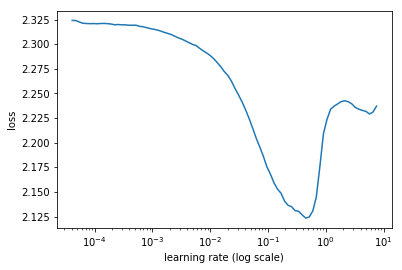

In [8]:
learn = get_learner(wrn_22(), 512)
learn.lr_find(wds=1e-4);
learn.sched.plot(n_skip_end=1)

In [9]:
%time learn.fit(1.5, 1, wds=1e-4, cycle_len=30, use_clr_beta=(15, 10, 0.95, 0.85));

epoch      trn_loss   val_loss   accuracy                 
    0      1.573556   1.72647    0.4493    
    1      1.183565   1.143529   0.602                    
    2      0.923626   1.084386   0.6601                    
    3      0.751374   0.939416   0.6931                    
    4      0.624622   0.733119   0.7505                    
    5      0.546254   0.6531     0.7835                    
    6      0.494375   0.987467   0.7103                    
    7      0.440412   0.589649   0.8017                    
    8      0.419131   0.829825   0.7408                    
    9      0.399562   0.449251   0.8463                    
    10     0.369673   0.532133   0.8163                    
    11     0.34413    0.535004   0.8317                    
    12     0.335859   0.445997   0.8539                    
    13     0.317184   0.444179   0.8518                    
    14     0.299086   0.610063   0.8066                    
    15     0.286898   0.5563     0.829                    

[array([0.22234]), 0.9413000007629394]

In [10]:
get_TTA_accuracy(learn)

0.9437

## With tweaks for training locally on a 1080ti 

I will run the training 3 times just to make sure we hit 94% accuracy with some degree of reliability.

I need to not render the progress bars during training as else the updates from tqdm with this small of a batch size will overheat my laptop and it will shut down.

In [11]:
%%time
%%capture
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))
acc = get_TTA_accuracy(learn)

CPU times: user 9min 10s, sys: 4min 26s, total: 13min 37s
Wall time: 13min 29s


In [12]:
acc

0.9426

In [13]:
%%time
%%capture
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))
acc = get_TTA_accuracy(learn)

CPU times: user 9min 9s, sys: 4min 27s, total: 13min 37s
Wall time: 13min 29s


In [14]:
acc

0.9428

In [15]:
%%time
%%capture
learn = get_learner(wrn_22(), 128)
learn.clip = 1e-1
learn.fit(1.5, 1, wds=1e-4, cycle_len=20, use_clr_beta=(12, 15, 0.95, 0.85))
acc = get_TTA_accuracy(learn)

CPU times: user 9min 9s, sys: 4min 28s, total: 13min 37s
Wall time: 13min 29s


In [16]:
acc

0.9416

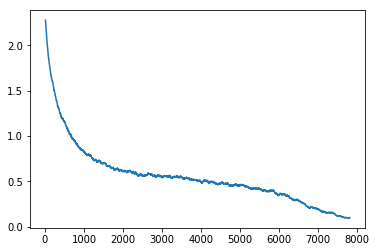

In [17]:
learn.sched.plot_loss()

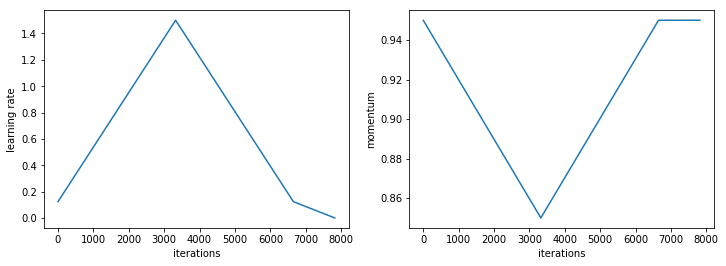

In [18]:
learn.sched.plot_lr()